# Assignment 2

The main idea of this assignment is to understand **Convolutional Neural Networks** and the basics of **image filtering**. We will implement matrix convolution as well as the convolutional layer from scratch.

**Please note:**
1. Please copy the code from the previous assignment (week 2) into a separate file `Blocks.py`. Make sure it resides in the same folder as this notebook. It should contain the implementation of the building blocks. 
2. All functions should be implemented using [**NumPy**](https://docs.scipy.org/doc/).

## Table of contents

* [0. Before you begin](#0.-Before-you-begin)
* [1. Recap](#1.-Recap)
* [2. Matrix Convolution](#2.-Matrix-Convolution) (mandatory)
* [3. Basic Kernels](#3.-Basic-Kernels) (mandatory)
* [4. Convolutional Layer](#4.-Convolutional-Layer)
* [5. MaxPooling Layer](#5.-MaxPooling-Layer) (mandatory)
* [6. Flatten](#6.-Flatten)
* [7. Experiments](#7.-Experiments)

# 0. Before you begin

Run the following block once when you start this notebook.  
It imports [NumPy](https://docs.scipy.org/doc/), [Matplotlib](https://matplotlib.org/), AutoMark, and your `Blocks.py` implementations from last week.  
We will make use of these imports during the course of this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Blocks import *
import automark as am
%matplotlib inline

In [85]:
# fill in your studentnumber as your username again
username = '12203610'

# get your progress by running this function
am.get_progress(username)

---------------------------------------------
| Xavi Moreno Liceras                       |
| xaviml.93@gmail.com                       |
---------------------------------------------
| [MAN] box_blur           | completed      |
| [MAN] conv_matrix        | completed      |
| [MAN] dense_forward      | completed      |
| [MAN] dense_grad_W       | completed      |
| [MAN] dense_grad_b       | completed      |
| [MAN] dense_grad_input   | completed      |
| [MAN] flatten_forward    | completed      |
| [MAN] flatten_grad_input | completed      |
| [MAN] hinge_forward      | completed      |
| [MAN] hinge_grad_input   | completed      |
| [MAN] l2_regularizer     | completed      |
| [MAN] maxpool_forward    | completed      |
| [MAN] relu_forward       | completed      |
| [MAN] relu_grad_input    | completed      |
| [OPT] dropout_forward    | completed      |
| [OPT] dropout_grad_input | completed      |
| [OPT] mse_forward        | completed      |
| [OPT] mse_grad_input     | compl

# 1. Recap

During the previous assignment, you implemented the main building blocks of neural networks:
* **Dense Layer**
* Non-linearity with ReLU
* Loss functions
* Optimization

Dense layers can already be very useful. They perform the following mapping on the input matrix $X$ (matrix of objects) using the weights $W$: 
$$
H = XW + b
$$

The dense layer enables creation and training of flexible models.

Now, let's take a look at image processing using **Dense Layer**:
1. We have a grayscale image $x$ of size $N \times M$ (width & height)
2. We reshape it into a vector of length $NM$
3. Then we map it with a dense layer
4. And obtain the transformed vector $y$

Each element of $y$ depends on each element of $x$. That's why its also called **fully connected**.  
A neural network which only consists of dense layers is therefore called a fully connected network.  

When we work with images, we assume that each pixel is correlated with its neighbours and close pixels. Distant pixels are not correlated. Various experiments demonstrate that this assumption is correct.

Dense layers captures these correlations, but they also capture *noisy* correlations to all other pixels.  

# 2. Matrix Convolution


There is a way to create a **locally connected** layer which will learn local correlations using a smaller amount of parameters.  
This layer is aptly called **Convolutional Layer** and is based on **matrix convolution**

A picture is worth a thousand words which is especially true when learning about convolution:
![Image convolution](https://camo.githubusercontent.com/709b7f5eb5203b41f9456f887787b6ea790878b5/68747470733a2f2f636f6d6d756e6974792e61726d2e636f6d2f6366732d66696c652f5f5f6b65792f636f6d6d756e6974797365727665722d626c6f67732d636f6d706f6e656e74732d7765626c6f6766696c65732f30302d30302d30302d32302d36362f343738362e636f6e762e706e67)

In image convolution, a **filter**, also called **kernel**, is applied to the source matrix.  
Each element from the kernel is multiplied by the corresponding element from the source matrix. The results are summed up and written to the target matrix.

In this example, the output matrix has a smaller size than its source\*. This is because the kernel can not overlap the borders. **Zero padding** can be used to retain the original dimension. It is a simple solution which involves adding a border of zeros to the input.

\* It may seem both matrices have the same size (both are shown with the same number of boxes. In the edges of the right matrix, however, no values are stored. The top-left corner of the right image starts where the $-3$ is placed.

The source matrix $X$ is of size $N \times M$ and the kernel $K$ is of size $(2p+1) \times (2q +1 )$.  
We define $X_{ij} = 0$ for $i > N, i < 1$ and $j > M, j < 1$.  
In (other) words: If you try to access a pixel which is out of bounds assume that it is zero.  
This is called **zero padding**.

Therefore, the convolution of a matrix with a kernel is defined as follows:
$$
Y = X \star K \\
Y_{ij} = \sum\limits_{\alpha=0}^{2p} \sum\limits_{\beta=0}^{2q}
K_{\alpha \beta} X_{i + \alpha - p, j+\beta - q}
$$

This operation's name depends on the field:
* In machine learning: **convolution**
* In mathematics: **cross-correlation**

Finally, its time for you to implement matrix convolution.  
You can use the example below this code block to test your implementation.

In [69]:
def conv_matrix(matrix, kernel):
    """Perform the convolution of the matrix 
        with the kernel using zero padding
    # Arguments
        matrix: input matrix np.array of size `(N, M)`
        kernel: kernel of the convolution 
            np.array of size `(2p + 1, 2q + 1)`
    # Output
        the result of the convolution
        np.array of size `(N, M)`
    """
    #################
    p = (kernel.shape[0]-1) // 2
    q = (kernel.shape[1]-1) // 2
    output = np.zeros(matrix.shape)
    N = output.shape[0]
    M = output.shape[1]
    for i in range(N):
        for j in range(M):
            for alpha in range(2*p+1):
                for beta in range(2*q+1):
                    idx_i = i+alpha-p
                    idx_j = j+beta-q
                    if idx_i > N-1 or idx_i < 0 or idx_j > M-1 or idx_j < 0:
                        val = 0
                    else:
                        val = matrix[idx_i, idx_j] 
                    output[i, j] += kernel[alpha, beta]*val       
    #################
    return output

Let's test the function with the following data:

$$
X = \begin{bmatrix}
1 & 2 & 3 \\
2 & 3 & 4 \\
3 & 4 & 5 \\
\end{bmatrix} \quad
K = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 2 \\
\end{bmatrix} \quad 
X \star K = 
\begin{bmatrix}
7 & 10 & 3 \\
10 & 14 & 6 \\
3 & 6 & 8 \\
\end{bmatrix}
$$

We recreate the example data in Python to perform a local test run.  
Don't be confused by [np.eye](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.eye.html). It fills our kernel matrix with ones on the diagonal from top-left to bottom-right.

In [70]:
X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5]
])

K = np.eye(3)
K[-1, -1] = 2
print(np.zeros(3))
print(K)

[0. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]


Run the following code block and compare the result with the example above.

In [71]:
print(conv_matrix(X, K))

[[ 7. 10.  3.]
 [10. 14.  6.]
 [ 3.  6.  8.]]


If you feel confident with your solution, check it against the AutoMark-server.

In [72]:
am.test_student_function(username, conv_matrix, ['matrix', 'kernel'])

Running local tests...
conv_matrix successfully passed local tests
Running remote test...
Test was successful. Congratulations!


# 3. Basic Kernels

Matrix convolution can be used to process an image (think Instagram): blur, shift, detecting edges, and much more.  
This [article](http://setosa.io/ev/image-kernels/) (**recommended read**) about image kernels should give you a better understanding of convolutions. It happens to be interactive as well.

In convolutional layers, the kernels are learned by training on the dataset. However, there are predefined kernels, for example used on your Instagram photos. Some examples are:

**Sharpen Kernel:** 
$$ 
\begin{equation*}
\begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0 
\end {bmatrix}
\end{equation*}
$$

**Edge detection filter:**
$$
\begin{equation*}
\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1 
\end {bmatrix}
\end{equation*}
$$

**Box blur of size 3:**
$$ \frac{1}{9}
\begin{equation*}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end {bmatrix}
\end{equation*}
$$

Let's play with convolutions by manipulating an image of a dog.

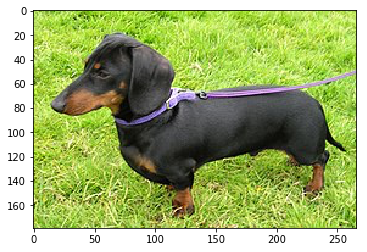

In [40]:
rgb_img = plt.imread('./images/dog.png')
plt.imshow(rgb_img)

Coloured images would require a 3-dimensional tensor to represent RGB (red, green, and blue).  
Therefore, we will convert it to grayscale. This way it can be processed as a matrix.

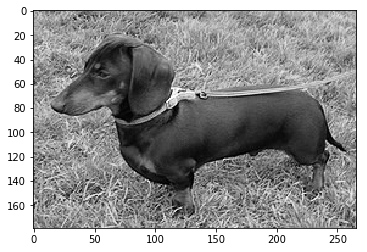

In [41]:
img = rgb_img.mean(axis=2)
plt.imshow(img, cmap='gray')

First of all, let's blur the image with [box blur](https://en.wikipedia.org/wiki/Box_blur). It is just a convolution of a matrix with the kernel of size $N \times N$ of the following form:

$$
\frac{1}{N^2}
\begin{bmatrix}
1 & \dots  & 1\\
\vdots & \ddots & \vdots\\
1 & \dots  & 1\\
\end{bmatrix}
$$

Every element of this filter is *one* and we divide the sum by the total amount of elements in the blur filter. You could understand it as taking the average of an image region.

**Description:**  
Perform the blur of the image.

<u>Arguments:</u>
* `image` - Input matrix - [np.array](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.array.html) of size `(N, M)`
* `box_size` - Size of the blur kernel - `int > 0` the kernel is of size `(box_size, box_size)`

<u>Output:</u>  
The result of the blur [np.array](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.array.html) of size `(N, M)`

In [66]:
def box_blur(image, box_size):
    """Perform the blur of the image
    # Arguments
        image: input matrix - np.array of size `(N, M)`
        box_size: the size of the blur kernel - int > 0  
            the kernel is of size `(box_size, box_size)`
    # Output
        the result of the blur
            np.array of size `(N, M)`
    """   
    #################
    kernel = np.ones((box_size, box_size)) / np.power(box_size, 2)
    output = conv_matrix(image, kernel)
    #################
    return output

You can test your solution before submitting it. Running the following code block should yield this result:
$$ 
\begin{equation*}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 
\end {bmatrix}
\end{equation*}
$$

In [67]:
test_image = np.array([
    [9, 0, 9],
    [0, 0, 0],
    [9, 0, 9]
])

print(box_blur(test_image, 3))

[[1. 2. 1.]
 [2. 4. 2.]
 [1. 2. 1.]]


Submit your solution here:

In [68]:
am.test_student_function(username, box_blur, ['image', 'box_size'])

Running local tests...
box_blur successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Let's apply your blur convolution on our dog:

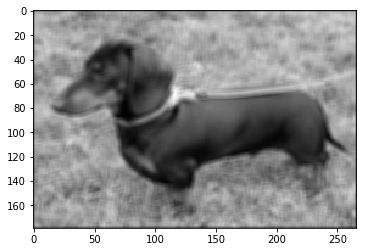

In [45]:
blur_dog = box_blur(img, box_size=5)
plt.imshow(blur_dog, cmap='gray')

Now, we will get the vertical and horizontal gradients. To perform it we calculate the convolution of the image with the following kernels:

$$
K_h = 
\begin{bmatrix}
-1 & 0  & 1\\
\end{bmatrix} \quad
K_v = 
\begin{bmatrix}
1 \\
0 \\
-1\\
\end{bmatrix} \\
X_h = X \star K_h \quad X_v = X \star K_v\\
$$

And then we calculate the amplitude of the gradient:

$$
X_\text{grad} = \sqrt{X_h^2 + X_v^2}
$$

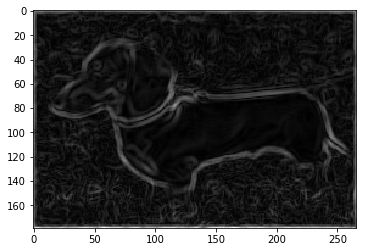

In [46]:
dog_h = conv_matrix(blur_dog, np.array([[-1, 0, 1]]))
dog_v = conv_matrix(blur_dog, np.array([[-1, 0, 1]]).T)
dog_grad = np.sqrt(dog_h ** 2 + dog_v ** 2)
plt.imshow(dog_grad, cmap='gray')

This yields the edges of our blurred dog. It is not the only way to obtain edges though, there are plenty more:
* [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector)
* [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)
* [Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator)

When you convolve an image with a kernel you obtain a map of responses. The more correlated the patch of an image is with the kernel, the higher the response. Let's take a closer look:

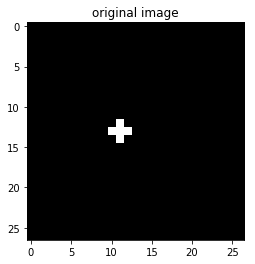

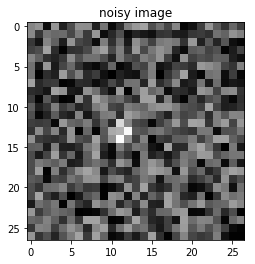

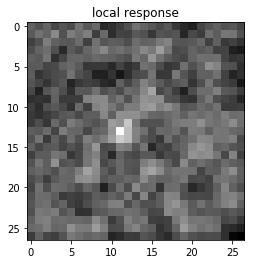

In [47]:
pattern = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
# Create the image
image = np.pad(pattern, [(12, 12), (10, 14)], mode='constant', constant_values=0)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

# Add some noise
image = 0.5 * image + 0.5 * np.random.random(image.shape)
plt.imshow(image, cmap='gray')
plt.title('noisy image')
plt.show()

# Let's find the cross 
response = conv_matrix(image, pattern)
plt.imshow(response, cmap='gray')
plt.title('local response')
plt.show()

The brightest pixel highlights where the cross is located. We can find the area where the image is locally close to the kernel. This is especially useful for finding different patterns in images such as: eyes, legs, dogs, cats, etc.

We defined kernels and applied them to images. But we can also learn them by minimizing loss and making the processing as effective as possible. In order to do this, we have to define the **Convolutional Layer** in the next chapter.

# 4. Convolutional Layer

A **Convolutional Layer** works with images. Each image is a 3-dimensional object  $N_{\text{channels}} \times H \times W$.  
$Channels$ refers to the 3 colors (or 1 for black & white images), $H$ to height, and $W$ to width.  
And therefore, the collection of images is 4-dimensional tensor of shape $N_{\text{objects}} \times N_{\text{channels}} \times H \times W$.

For example, 32 RGB images of size $224 \times 224$ are represented as a tensor of shape $32 \times 3 \times 224 \times 224$

A convolutional layer receives an image as its input. Here is how it works:  
The layer has `n_in * n_out` kernels. It is a tensor of size `(n_in, n_out, kernel_h, kernel_w)`  
It takes a 4-dimensional tensor of size `n_objects, n_in, H, W` as its input. 
* `n_objects` is the collection of images. 
* Each of them has `n_in` channels.
* The resolution of the images is `(H, W)`

For each of the images the following operation is performed:  
* In order to get the 1st output channel, all inputs are convolved with their corresponding kernels.  
* Then the results are summed and written to the output channel.  
This is our implementation:
```python
for i in range(n_out):
    out_channel = 0.0
    for j in range(n_in):
        kernel_2d = K[i, j] # Retrieve kernel from the collection of kernels
        input_channel = input_image[j] # Get one channel of the input iamge
        out_channel += conv_matrix(input_channel, kernel_2d) # Perform convolution
    output_image.append(out_channel) # Append the calculated channel to the output          
```

We implemented the convolutional layer for you. The implementation of `backward` is based on the idea that convolution could be represented as matrix multiplication.

In [48]:
class ConvLayer(Layer):
    """
    Convolutional Layer. The implementation is based on 
        the representation of the convolution as matrix multiplication
    """
    
    def __init__(self, n_in, n_out, filter_size):
        super(ConvLayer, self).__init__()
        self.W = np.random.normal(size=(n_out, n_in, filter_size, filter_size))
        self.b = np.zeros(n_out)
        
    def forward(self, x_input):
        n_obj, n_in, h, w = x_input.shape
        n_out = len(self.W)
        
        self.output = []
        
        for image in x_input:
            output_image = []
            for i in range(n_out):
                out_channel = 0.0
                for j in range(n_in):
                    out_channel += conv_matrix(image[j], self.W[i, j])
                output_image.append(out_channel)
            self.output.append(np.stack(output_image, 0))

        self.output = np.stack(self.output, 0)
        return self.output

    
    def backward(self, x_input, grad_output):

        N, C, H, W = x_input.shape 
        F, C, HH, WW = self.W.shape
        
        pad = int((HH - 1) / 2)

        self.grad_b = np.sum(grad_output, (0, 2, 3)) 

        # pad input array
        x_padded = np.pad(x_input, ((0,0), (0,0), (pad, pad), (pad, pad)), 'constant')
        H_padded, W_padded = x_padded.shape[2], x_padded.shape[3]
        # naive implementation of im2col
        x_cols = None
        for i in range(HH, H_padded + 1):
            for j in range(WW, W_padded+1):
                for n in range(N):
                    field = x_padded[n, :, i-HH:i, j-WW:j].reshape((1,-1))    
                    if x_cols is None:
                        x_cols = field
                    else:
                        x_cols = np.vstack((x_cols, field))
                        
        x_cols = x_cols.T

        d_out = grad_output.transpose(1, 2, 3, 0) 
        dout_cols = d_out.reshape(F, -1) 

        dw_cols = np.dot(dout_cols, x_cols.T) 
        self.grad_W = dw_cols.reshape(F, C, HH, WW) 

        w_cols = self.W.reshape(F, -1) 
        dx_cols = np.dot(w_cols.T, dout_cols) 

        dx_padded = np.zeros((N, C, H_padded, W_padded))
        idx = 0
        for i in range(HH, H_padded + 1):
            for j in range(WW, W_padded + 1):
                for n in range(N):
                    dx_padded[n:n+1, :, i-HH:i, j-WW:j] += dx_cols[:, idx].reshape((1, C, HH, WW))
                    idx += 1
            dx = dx_padded[:, :, pad:-pad, pad:-pad]
        grad_input = dx
        return grad_input
    
    def get_params(self):
        return [self.W, self.b]

    def get_params_gradients(self):
        return [self.grad_W, self.grad_b]

This layer transforms images with 3 channels into images with 8 channels by convolving them with kernels of size `(3, 3)`

In [49]:
conv_layer = ConvLayer(3, 8, filter_size=3)

# 5. Pooling Layer

The pooling layer **reduces the size of an image**. 

In the following figure $2 \times 2$ pooling is applied on the image which effectively reduces the size by half.  
If you look closely, pooling operations have no effect on the depth of an image.
![pool](./src/pool.png)

There are several types of pooling operations but the most common one is **max pooling**. 

During a max pooling operation, the image is split into **windows** (or **filters**) and then the maximum of each window is used as the output.

![maxpool](./src/maxpool.png)

In [63]:
def maxpool_forward(x_input):
    """Perform max pooling operation with 2x2 window
    # Arguments
        x_input: np.array of size (2 * W, 2 * H)
    # Output
        output: np.array of size (W, H)
    """
    #################
    W = x_input.shape[0] // 2
    H = x_input.shape[1] // 2
    output = np.empty((W,H))
    for i in range(W):
        for j in range(H):
            sub_matrix = x_input[2*i:2*i+2, 2*j:2*j+2]
            output[i,j] = np.max(sub_matrix)
    ################# 
    return output

Once again, you can use example data to test your solution:  
**Image:**
$$ 
\begin{equation*}
\begin{bmatrix}
1 & 1 & 2 & 4 \\
5 & 6 & 7 & 8 \\
3 & 2 & 1 & 0 \\
1 & 2 & 3 & 4
\end {bmatrix}
\end{equation*}
$$

**Output:**
$$ 
\begin{equation*}
\begin{bmatrix}
6 & 8 \\
3 & 4
\end {bmatrix}
\end{equation*}
$$

In [64]:
test_image = np.array([
    [1, 1, 2, 4],
    [5, 6, 7, 8],
    [3, 2, 1, 0],
    [1, 2, 3, 4]
])

print(maxpool_forward(test_image))

[[6. 8.]
 [3. 4.]]


Submit your solution once you are confident it is implemented correctly.

In [65]:
am.test_student_function(username, maxpool_forward, ['x_input'])

Running local tests...
maxpool_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


We already implemented the gradient calculation.  
It is not overly complicated; reading the code should help you to understand the concept.

In [61]:
def maxpool_grad_input(x_input, grad_output):
    """Calculate partial derivative of the loss with respect to the input
    # Arguments
        x_input: np.array of size (2 * W, 2 * H)
        grad_output: partial derivative of the loss 
            with respect to the output 
            np.array of size (W, H)
    # Output
        output: partial derivative of the loss 
            with respect to the input
            np.array of size (2 * W, 2 * H) 
    """
    height, width = x_input.shape
    # Create an array of zeros the same size as the input
    grad_input = np.zeros(x_input.shape)
    
    # We set 1 if the element is the maximum in its window
    for i in range(0, height, 2):
        for j in range(0, width, 2):
            window = x_input[i:i+2, j:j+2]
            i_max, j_max = np.unravel_index(np.argmax(window), (2, 2))
            grad_input[i + i_max, j + j_max] = 1
            
    # Overwrite with the corresponding gradient instead of 1       
    grad_input = grad_input.ravel()
    grad_input[grad_input == 1] = grad_output.ravel()
    grad_input = grad_input.reshape(x_input.shape)
    return grad_input

Following up is the full implementation of the **MaxPool Layer**.

In [62]:
class MaxPool2x2(Layer):
    
    def forward(self, x_input):
        n_obj, n_ch, h, w = x_input.shape
        self.output = np.zeros((n_obj, n_ch, h // 2, w // 2))
        for i in range(n_obj):
            for j in range(n_ch):
                self.output[i, j] = maxpool_forward(x_input[i, j])
        return self.output 
    
    def backward(self, x_input, grad_output):
        n_obj, n_ch, _, _ = x_input.shape
        grad_input = np.zeros_like(x_input)
        for i in range(n_obj):
            for j in range(n_ch):
                grad_input[i, j] = maxpool_grad_input(x_input[i, j], grad_output[i, j])
        return grad_input

# 6. Flatten

Convolutional neural networks are better at image processing than fully connected neural networks (dense networks). We will combine convolutional layers, which deal with 4-dimensional tensors, with dense layers, which work with matrices.  
In order to bridge the gap between convolutional layers and dense layers we will implement the **Flatten Layer**.

The Flatten layer receives a 4-dimensional tensor of size `(n_obj, n_channels, h, w)` as its input and reshapes it into a 2-dimensional tensor (matrix) of size `(n_obj, n_channels * h * w)`.  

The backward pass of this layer is pretty straightforward. Remember that we don't actually change any values; we merely reshape inputs.

**Please implement `flatten_forward` and `flatten_grad_input` functions using [np.reshape](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html)**.

In [73]:
def flatten_forward(x_input):
    """Perform the reshaping of the tensor of size `(K, L, M, N)` 
        to the tensor of size `(K, L*M*N)`
    # Arguments
        x_input: np.array of size `(K, L, M, N)`
    # Output
        output: np.array of size `(K, L*M*N)`
    """
    #################
    K = x_input.shape[0]
    L = x_input.shape[1]
    M = x_input.shape[2]
    N = x_input.shape[3]
    output = np.reshape(x_input, (K, L*M*N))
    #################
    return output

You can use test data and compare the final shape. It should be `(100, 768)` for the following example.  
Please ignore the use of [np.zeros](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.zeros.html) in this case. We are just interested in transforming shapes.  
**Be aware:** This test will fail if you do not return an array like object!

In [74]:
test_input = np.zeros((100, 3, 16, 16))

print(flatten_forward(test_input).shape)

(100, 768)


Submit your solution here:

In [75]:
am.test_student_function(username, flatten_forward, ['x_input'])

Running local tests...
flatten_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [82]:
def flatten_grad_input(x_input, grad_output):
    """Calculate partial derivative of the loss with respect to the input
    # Arguments
        x_input: partial derivative of the loss 
            with respect to the output
            np.array of size `(K, L*M*N)`
    # Output
        output: partial derivative of the loss 
            with respect to the input
            np.array of size `(K, L, M, N)`
    """
    #################
    K = x_input.shape[0]
    L = x_input.shape[1]
    M = x_input.shape[2]
    N = x_input.shape[3]
    grad_input = np.reshape(grad_output, (K, L, M, N))
    #################
    return grad_input

Once again, submit your solution here:

In [83]:
am.test_student_function(username, flatten_grad_input, ['x_input', 'grad_output'])

Running local tests...
flatten_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


This is the, pretty self-explanatory, implemention of the **Flatten Layer**.

In [84]:
class FlattenLayer(Layer):
    
    def forward(self, x_input):
        self.output = flatten_forward(x_input)
        return self.output
    
    def backward(self, x_input, grad_output):
        output = flatten_grad_input(x_input, grad_output)
        return output

# 7. Experiments

This chapter focuses on conducting several experiments. We will train our neural networks with **mini-batches**. Mini-batches are small portions of our dataset, all mini-batches together should form the original dataset again. With our mini-batches in place we will feed these one-by-one to our neural network.

In [86]:
import sys

def iterate_minibatches(x, y, batch_size=16, verbose=True):
    assert len(x) == len(y)
    
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    
    for i, start_idx in enumerate(range(0, len(x) - batch_size + 1, batch_size)):
        if verbose:
            print('\rBatch: {}/{}'.format(i + 1, len(x) // batch_size), end='')
            sys.stdout.flush()
        
        excerpt = indices[start_idx:start_idx + batch_size]
        yield x[excerpt], y[excerpt]

Let's import the data. Please [download](http://yann.lecun.com/exdb/mnist/) it first.

If you get an error with loading the data, chances are you'll need to unpack the downloaded files.

In [87]:
from dataset_utils import load_mnist

In [90]:
train = list(load_mnist(dataset='training', path='dataset/'))
train
train_images = np.array([im[1] for im in train])
train_targets = np.array([im[0] for im in train])
# We will train a 0 vs. 1 classifier
x_train = train_images[train_targets < 2][:1000]
y_train = train_targets[train_targets < 2][:1000]

y_train = y_train * 2 - 1
y_train = y_train.reshape((-1, 1))

You just loaded the MNIST dataset. This dataset consists of gray-scale (so a single channel) images of size `28x28`. These images are represented by the RGB color model. This color model representes a color by 3 integers that range from 0 to 255, or in the case of gray-scale images this is a single integer. This means that each picture in the MNIST dataset is represented by 784 pixels with a value ranging from 0 to 255. This is how a single image looks like:

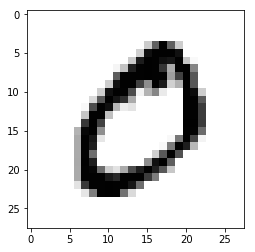

In [91]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray_r')

To make divergence to an optimum easier, we will normalize the images to have values between 0 and 1. Then, by reshaping, we will add the dimensions for the channel which, for simplicity, was removed by the creators of this dataset. As you can see, this doesn't change anything in how the image looks like.

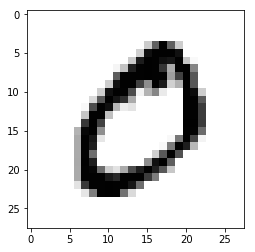

In [92]:
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape((-1, 1, 28, 28))
plt.imshow(x_train[0].reshape(28, 28), cmap='gray_r')

Now we will train a simple convolutional neural network:

In [93]:
def get_cnn():
    nn = SequentialNN()

    nn.add(ConvLayer(1, 2, filter_size=3)) # The output is of size N_obj 2 28 28
    nn.add(ReLU()) # The output is of size N_obj 2 28 28
    nn.add(MaxPool2x2()) # The output is of size N_obj 2 14 14

    nn.add(ConvLayer(2, 4, filter_size=3)) # The output is of size N_obj 4 14 14
    nn.add(ReLU()) # The output is of size N_obj 4 14 14
    nn.add(MaxPool2x2()) # The output is of size N_obj 4 7 7

    nn.add(FlattenLayer()) # The output is of size N_obj 196
    nn.add(Dense(4 * 7 * 7, 32))
    nn.add(ReLU())
    nn.add(Dense(32, 1))
    return nn

In [94]:
nn = get_cnn()
loss = Hinge()
optimizer = SGD(nn)

In [95]:
# It will train for about 5 minutes
num_epochs = 5 
batch_size = 32
# We will store the results here
history = {'loss': [], 'accuracy': []}

# `num_epochs` represents the number of iterations
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    
    # We perform iteration a one-by-one iteration of the mini-batches
    for x_batch, y_batch in iterate_minibatches(x_train, y_train, batch_size):
        # Predict the target value
        y_pred = nn.forward(x_batch)
        # Compute the gradient of the loss
        loss_grad = loss.backward(y_pred, y_batch)
        # Perform backwards pass
        nn.backward(x_batch, loss_grad)
        # Update the params
        optimizer.update_params()
        
        # Save loss and accuracy values
        history['loss'].append(loss.forward(y_pred, y_batch))
        prediction_is_correct = (y_pred > 0) == (y_batch > 0)
        history['accuracy'].append(np.mean(prediction_is_correct))
        
    print()

Epoch 1/5
Batch: 31/31
Epoch 2/5
Batch: 31/31
Epoch 3/5
Batch: 31/31
Epoch 4/5
Batch: 31/31
Epoch 5/5
Batch: 31/31


Text(0,0.5,'accuracy')

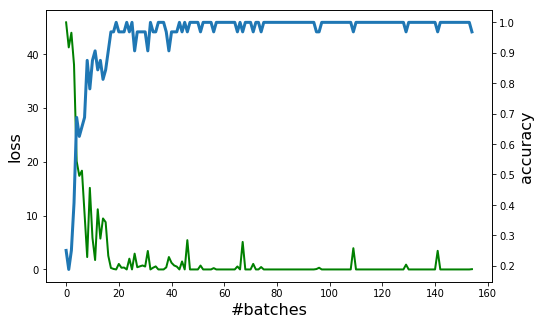

In [96]:
# Let's plot the results to get a better insight
plt.figure(figsize=(8, 5))

ax_1 = plt.subplot()
ax_1.plot(history['loss'], c='g', lw=2, label='train loss')
ax_1.set_ylabel('loss', fontsize=16)
ax_1.set_xlabel('#batches', fontsize=16)

ax_2 = plt.twinx(ax_1)
ax_2.plot(history['accuracy'], lw=3, label='train accuracy')
ax_2.set_ylabel('accuracy', fontsize=16)

**Things you could try:**  
Train the model with a different `batch_size`:
* What would happen with `batch_size=1`?
* What would happen with `batch_size=1000`?
* Does the speed of the computation depend on this parameter? If so, why?

Train the model with a different number of `num_epochs`:
* What would happen with `num_epochs=1`?
* What would happen with `num_epochs=1000`?
* How does it affect computation time, resource strain, and accuracy?

Let's visualize the activations of the intermediate layers:

In [97]:
viz_images = x_batch[:2]
_ = nn.forward(viz_images)

activations = {
    'conv_1': nn.layers[0].output,
    'relu_1': nn.layers[1].output,
    'pool_1': nn.layers[2].output,
    'conv_2': nn.layers[3].output,
    'relu_2': nn.layers[4].output,
    'pool_2': nn.layers[5].output,
}

### Input Images

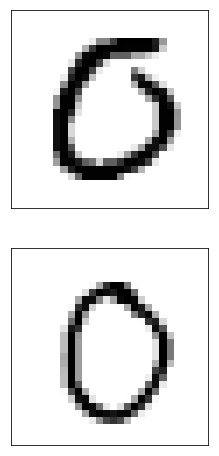

In [98]:
# Input
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))

ax1.imshow(viz_images[0, 0], cmap=plt.cm.gray_r)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(viz_images[1, 0], cmap=plt.cm.gray_r)
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

### Activations of Conv 1

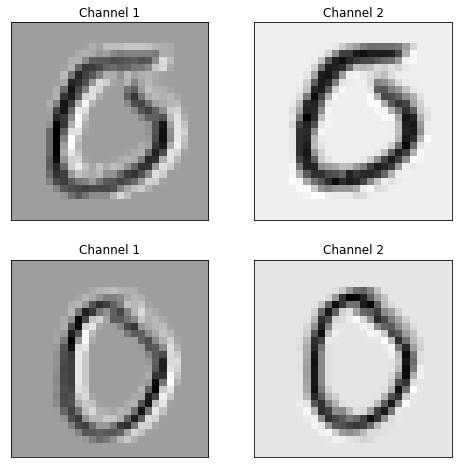

In [99]:
# Conv 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['conv_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of ReLU 1

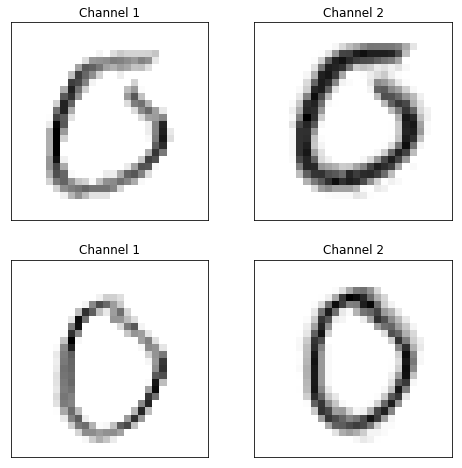

In [100]:
# ReLU 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['relu_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of MaxPooling 1

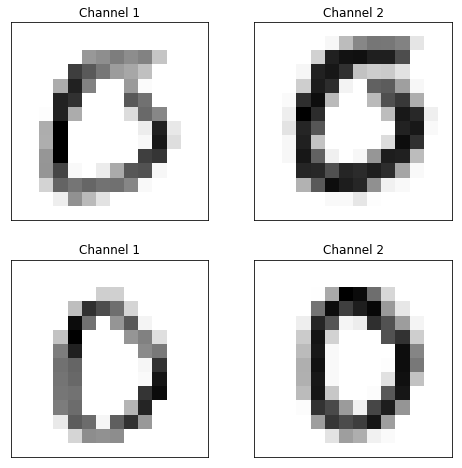

In [101]:
# Max Pooling 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['pool_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of Conv 2

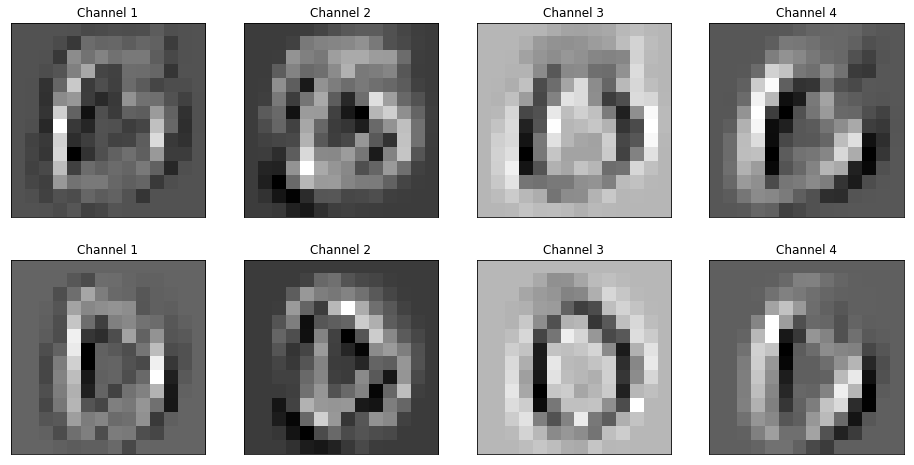

In [102]:
# Conv 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['conv_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of ReLU 2

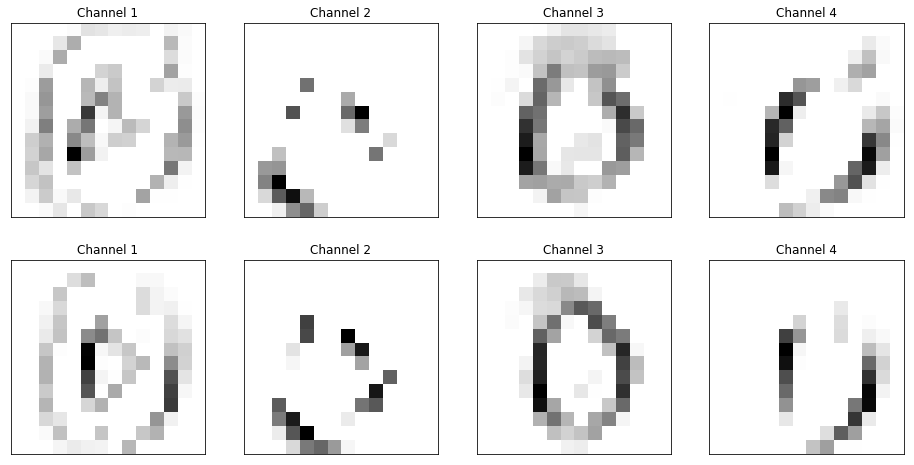

In [103]:
# ReLU 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['relu_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of MaxPooling 2

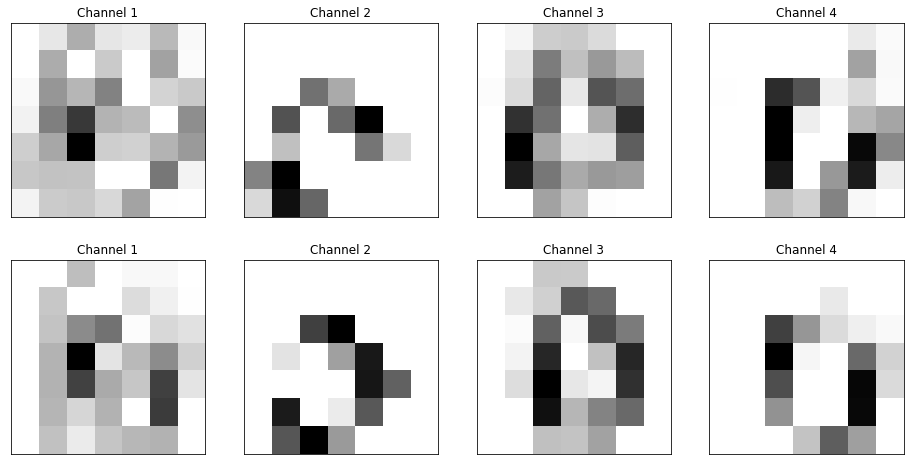

In [104]:
# Max Pooling 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['pool_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

As we go deeper and deeper, images become less locally-correlated (the dependance between two neighbours decreases) and more semantically loaded.  
Each convoluted pixel stores more and more useful information about the object.  
In the end, this will be anaylzed using several **Dense Layers**.

**Things you could try:**
* Change the architecture of the neural network
* Vary the number of kernels
* Vary the size of the kernels